In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

import joblib
import warnings
warnings.filterwarnings("ignore")


In [3]:
DATA_PATH = "/content/creditcard.csv"
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(df.info())
print("\nClass distribution:")
print(df['Class'].value_counts())
print("\nClass distribution (percent):")
print(df['Class'].value_counts(normalize=True) * 100)

display(df[['Time','Amount']].describe().T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16


In [5]:
df['TransactionHour'] = (df['Time'] // 3600) % 24

df['Amount_Log'] = np.log1p(df['Amount'])

df['Amt_per_Time'] = df['Amount'] / (df['Time'] + 1)

v_cols = [f"V{i}" for i in range(1,29)]
df['row_variance'] = df[v_cols].var(axis=1)

df[['TransactionHour','Amount_Log','Amt_per_Time','row_variance']].head()


,TransactionHour,Amount_Log,Amt_per_Time,row_variance
0,0.0,5.014760,149.62,0.554115
1,0.0,1.305626,2.69,0.238856
2,0.0,5.939276,189.33,1.367781
3,0.0,4.824306,61.75,0.672161
4,0.0,4.262539,23.33,0.432479


In [6]:
df = df.drop(columns=['Time','Amount'])
print("After drop shape:", df.shape)


After drop shape: (284807, 33)


In [7]:
X = df.drop('Class', axis=1)
y = df['Class']
print("Feature shape:", X.shape, "Target shape:", y.shape)


Feature shape: (284807, 32) Target shape: (284807,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts())


Train: (227845, 32) Test: (56962, 32)
Train class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, random_state=42)   # probability=True so we can get ROC-AUC
}


In [11]:
trained_models = {}
for name, model in models.items():
    print("Training:", name)
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
print("Training complete.")


Training: Logistic Regression
Training: Random Forest
Training: SVM
Training complete.


In [12]:
metrics = {}

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc, "confusion_matrix": cm, "y_proba": y_proba, "y_pred": y_pred}

for name, model in trained_models.items():
    metrics[name] = evaluate_model(name, model, X_test_scaled, y_test)

metrics_df = pd.DataFrame({name: {k:v for k,v in metrics[name].items() if k!='confusion_matrix' and k!='y_proba' and k!='y_pred'} for name in metrics})
metrics_df = metrics_df.T[['accuracy','precision','recall','f1','auc']]
metrics_df


,accuracy,precision,recall,f1,auc
Logistic Regression,0.972719,0.054468,0.908163,0.102771,0.971822
Random Forest,0.999596,0.941176,0.816327,0.874317,0.957116
SVM,0.999438,0.958333,0.704082,0.811765,0.973147


In [13]:
for name, info in metrics.items():
    print(f"\n=== {name} ===")
    print("Confusion Matrix:\n", info['confusion_matrix'])
    print("\nClassification Report:")
    print(classification_report(y_test, info['y_pred'], digits=4))



=== Logistic Regression ===
Confusion Matrix:
 [[55319  1545]
 [    9    89]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9728    0.9861     56864
           1     0.0545    0.9082    0.1028        98

    accuracy                         0.9727     56962
   macro avg     0.5272    0.9405    0.5445     56962
weighted avg     0.9982    0.9727    0.9846     56962


=== Random Forest ===
Confusion Matrix:
 [[56859     5]
 [   18    80]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9412    0.8163    0.8743        98

    accuracy                         0.9996     56962
   macro avg     0.9704    0.9081    0.9371     56962
weighted avg     0.9996    0.9996    0.9996     56962


=== SVM ===
Confusion Matrix:
 [[56861     3]
 [   29    69]]

Classification Report:
              precision    recall  f1-score   support

    

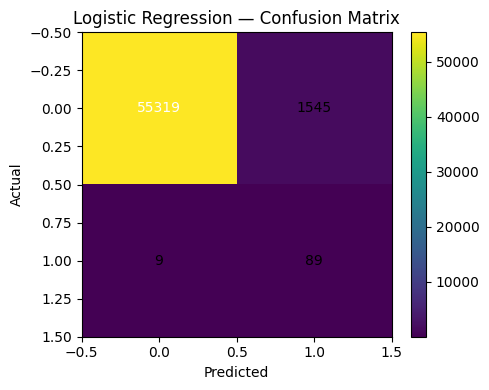

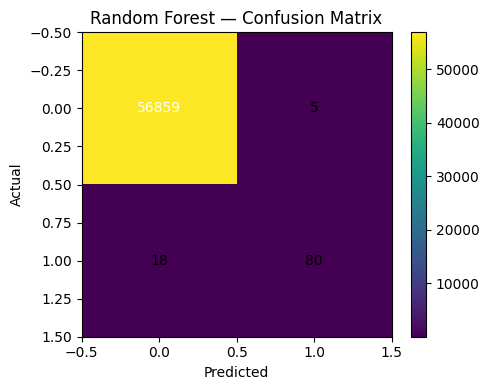

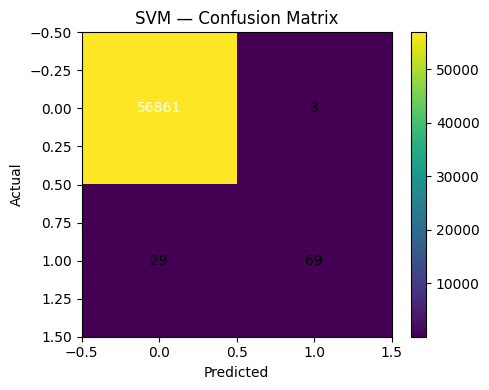

In [14]:
for name, info in metrics.items():
    cm = info['confusion_matrix']
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(f"{name} — Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha='center', va='center', color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.tight_layout()
    plt.show()


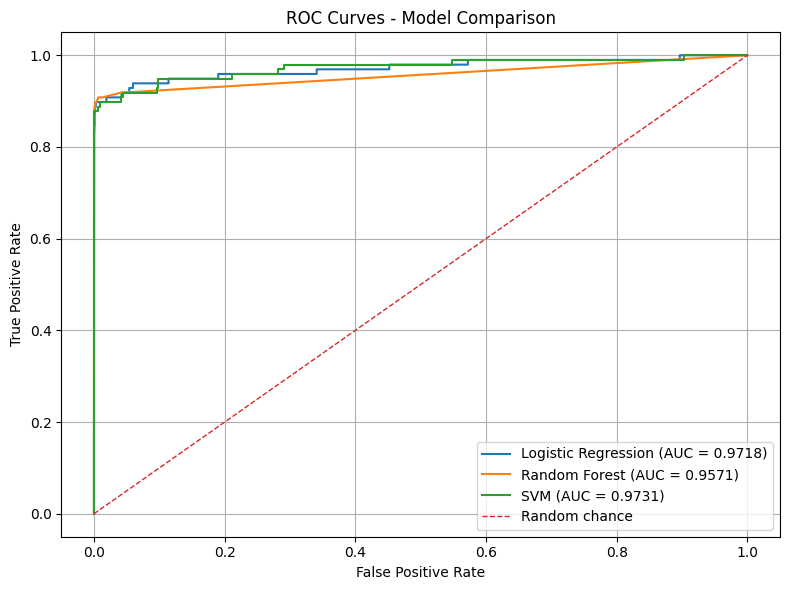

In [15]:
plt.figure(figsize=(8,6))
for name, info in metrics.items():
    fpr, tpr, _ = roc_curve(y_test, info['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {info['auc']:.4f})")
plt.plot([0,1],[0,1], linestyle='--', linewidth=1, label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


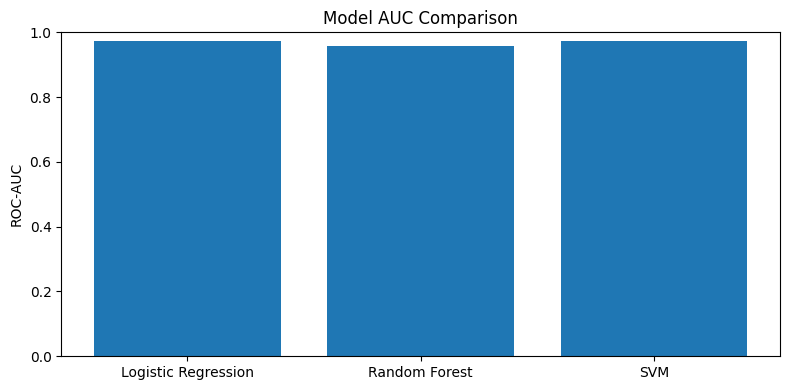

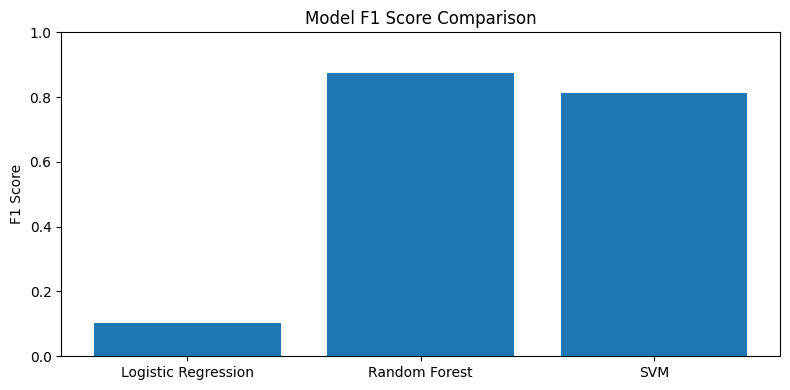

Best model by ROC-AUC: SVM (AUC = 0.9731)

What is F1 Score?
F1 is the harmonic mean of Precision and Recall.
It is useful for imbalanced datasets because it penalizes both false positives and false negatives.


In [18]:

import numpy as np
import matplotlib.pyplot as plt

names = list(metrics.keys())

auc_scores = [metrics[n]['auc'] for n in names]
f1_scores = [metrics[n]['f1'] for n in names]

plt.figure(figsize=(8,4))
plt.bar(names, auc_scores)
plt.ylim(0.0, 1.0)
plt.title("Model AUC Comparison")
plt.ylabel("ROC-AUC")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
plt.bar(names, f1_scores)
plt.ylim(0.0, 1.0)
plt.title("Model F1 Score Comparison")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()


best_idx = int(np.argmax(auc_scores))
best_model_name = names[best_idx]
best_auc = auc_scores[best_idx]

print(f"Best model by ROC-AUC: {best_model_name} (AUC = {best_auc:.4f})")


print("\nWhat is F1 Score?")
print("F1 is the harmonic mean of Precision and Recall.")
print("It is useful for imbalanced datasets because it penalizes both false positives and false negatives.")
